<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BFortaleza%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/fortalezadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,21726.0,21726.000000,10553.000000,10839.000000,10860.000000,10207.000000,9784.000000,9849.000000,9357.000000,9613.000000,0.0
mean,82397.0,600.055233,4.265763,30.934828,23.884650,7.797972,4.595738,26.988259,77.710030,3.023573,NaN
std,0.0,600.013806,11.724447,1.188440,1.129653,3.181380,2.158916,0.923364,6.607162,1.013614,NaN
min,82397.0,0.000000,0.000000,25.000000,19.900000,0.000000,0.000000,23.120000,58.000000,0.000000,NaN
25%,82397.0,0.000000,0.000000,30.300000,23.100000,6.300000,3.000000,26.400000,72.750000,2.333333,NaN
50%,82397.0,1200.000000,0.000000,31.100000,23.800000,9.100000,4.500000,27.060000,76.750000,3.066667,NaN
75%,82397.0,1200.000000,2.300000,31.700000,24.700000,10.200000,6.000000,27.660000,82.000000,3.733333,NaN
max,82397.0,1200.000000,180.600000,37.000000,29.800000,11.800000,18.500000,29.660000,97.500000,7.866667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82397,1980-01-01,0,NaN,31.0,NaN,5.5,6.5,28.08,76.5,5.1,NaN
1,82397,1980-01-01,1200,0.0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2,82397,1980-01-02,0,NaN,31.2,NaN,6.6,5.1,NaN,NaN,NaN,NaN
3,82397,1980-01-02,1200,0.0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN
4,82397,1980-01-03,0,NaN,31.6,NaN,8.8,4.8,NaN,NaN,NaN,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,10839.000000,0.0,10207.000000,9784.000000,9849.000000,9357.000000,9613.000000
mean,NaN,30.934828,NaN,7.797972,4.595738,26.988259,77.710030,3.023573
std,NaN,1.188440,NaN,3.181380,2.158916,0.923364,6.607162,1.013614
min,NaN,25.000000,NaN,0.000000,0.000000,23.120000,58.000000,0.000000
25%,NaN,30.300000,NaN,6.300000,3.000000,26.400000,72.750000,2.333333
50%,NaN,31.100000,NaN,9.100000,4.500000,27.060000,76.750000,3.066667
75%,NaN,31.700000,NaN,10.200000,6.000000,27.660000,82.000000,3.733333
max,NaN,37.000000,NaN,11.800000,18.500000,29.660000,97.500000,7.866667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,10553.000000,0.0,10860.000000,0.0,0.0,0.0,0.0,0.0
mean,4.265763,NaN,23.884650,NaN,NaN,NaN,NaN,NaN
std,11.724447,NaN,1.129653,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,19.900000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,23.100000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,23.800000,NaN,NaN,NaN,NaN,NaN
75%,2.300000,NaN,24.700000,NaN,NaN,NaN,NaN,NaN
max,180.600000,NaN,29.800000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.0,5.5,6.5,28.08,76.5,5.1
1980-01-02,31.2,6.6,5.1,NaN,NaN,NaN
1980-01-03,31.6,8.8,4.8,NaN,NaN,NaN
1980-01-04,31.4,7.6,4.1,NaN,NaN,NaN
1980-01-05,32.0,7.6,5.6,NaN,NaN,NaN


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.0,26.0
1980-01-02,0.0,26.0
1980-01-03,0.0,26.0
1980-01-04,0.3,25.2
1980-01-05,0.0,25.0


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.0,5.5,6.5,28.08,76.5,5.1,0.0,26.0
1980-01-02,31.2,6.6,5.1,NaN,NaN,NaN,0.0,26.0
1980-01-03,31.6,8.8,4.8,NaN,NaN,NaN,0.0,26.0
1980-01-04,31.4,7.6,4.1,NaN,NaN,NaN,0.3,25.2
1980-01-05,32.0,7.6,5.6,NaN,NaN,NaN,0.0,25.0


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10839.000000,10207.000000,9784.000000,9849.000000,9357.000000,9613.000000,10553.000000,10860.000000
mean,30.934828,7.797972,4.595738,26.988259,77.710030,3.023573,4.265763,23.884650
std,1.188440,3.181380,2.158916,0.923364,6.607162,1.013614,11.724447,1.129653
min,25.000000,0.000000,0.000000,23.120000,58.000000,0.000000,0.000000,19.900000
25%,30.300000,6.300000,3.000000,26.400000,72.750000,2.333333,0.000000,23.100000
50%,31.100000,9.100000,4.500000,27.060000,76.750000,3.066667,0.000000,23.800000
75%,31.700000,10.200000,6.000000,27.660000,82.000000,3.733333,2.300000,24.700000
max,37.000000,11.800000,18.500000,29.660000,97.500000,7.866667,180.600000,29.800000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.0,5.5,6.5,28.08,76.5,5.1,0.0,26.0
1980-01-02,31.2,6.6,5.1,NaN,NaN,NaN,0.0,26.0
1980-01-03,31.6,8.8,4.8,NaN,NaN,NaN,0.0,26.0
1980-01-04,31.4,7.6,4.1,NaN,NaN,NaN,0.3,25.2
1980-01-05,32.0,7.6,5.6,NaN,NaN,NaN,0.0,25.0


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,5.5,6.5,28.08,76.5,5.1,0.0,26.0
1980-01-02,6.6,5.1,NaN,NaN,NaN,0.0,26.0
1980-01-03,8.8,4.8,NaN,NaN,NaN,0.0,26.0
1980-01-04,7.6,4.1,NaN,NaN,NaN,0.3,25.2
1980-01-05,7.6,5.6,NaN,NaN,NaN,0.0,25.0


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.0
1980-01-02    31.2
1980-01-03    31.6
1980-01-04    31.4
1980-01-05    32.0
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10184.000000,9761.000000,9848.000000,9334.000000,9590.000000,10527.000000,10837.000000
mean,0.324544,-0.502045,0.182939,-0.001661,-0.231683,-0.952645,-0.195098
std,0.536311,0.232475,0.282385,0.334676,0.257774,0.129978,0.228277
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.067797,-0.675676,0.003058,-0.253165,-0.406780,-1.000000,-0.353535
50%,0.542373,-0.513514,0.204893,-0.050633,-0.220339,-1.000000,-0.212121
75%,0.728814,-0.351351,0.388379,0.215190,-0.050848,-0.974529,-0.030303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(10839, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 734.6059 - mean_absolute_error: 26.9900
Epoch 2/200
 - 1s - loss: 444.2266 - mean_absolute_error: 20.9892
Epoch 3/200
 - 1s - loss: 261.0775 - mean_absolute_error: 16.0585
Epoch 4/200
 - 1s - loss: 140.0052 - mean_absolute_error: 11.7120
Epoch 5/200
 - 1s - loss: 65.5785 - mean_absolute_error: 7.9434
Epoch 6/200
 - 1s - loss: 25.4248 - mean_absolute_error: 4.8382
Epoch 7/200
 - 1s - loss: 7.9346 - mean_absolute_error: 2.5789
Epoch 8/200
 - 1s - loss: 2.5136 - mean_absolute_error: 1.3405
Epoch 9/200
 - 1s - loss: 1.5194 - mean_absolute_error: 0.9635
Epoch 10/200
 - 1s - loss: 1.4343 - mean_absolute_error: 0.9078
Epoch 11/200
 - 1s - los

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.350349, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.350349 (0.012559) {'batch_size': 10, 'camadas': 2, 'units': 7}


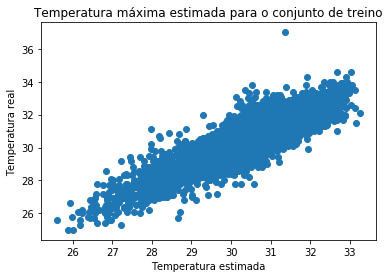

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.87683811]
 [0.87683811 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

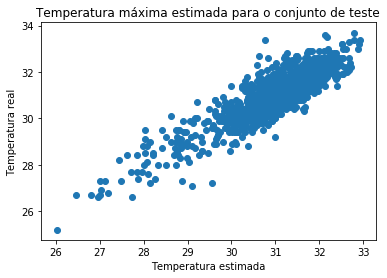

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.87994209]
 [0.87994209 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.41627715698467416


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.2908534229591599


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.0,5.5,6.5,28.08,76.5,5.1,0.0
1980-01-02,31.2,6.6,5.1,NaN,NaN,NaN,0.0
1980-01-03,31.6,8.8,4.8,NaN,NaN,NaN,0.0
1980-01-04,31.4,7.6,4.1,NaN,NaN,NaN,0.3
1980-01-05,32.0,7.6,5.6,NaN,NaN,NaN,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    26.0
1980-01-02    26.0
1980-01-03    26.0
1980-01-04    25.2
1980-01-05    25.0
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,10837.000000,10206.000000,9783.000000,9848.000000,9356.000000,9612.000000,10549.000000
mean,-0.010850,0.321778,-0.503116,0.182986,-0.002079,-0.231271,-0.952784
std,0.198090,0.539170,0.233361,0.282371,0.334514,0.257701,0.129806
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.116667,0.067797,-0.675676,0.003058,-0.253165,-0.406780,-1.000000
50%,0.016667,0.542373,-0.513514,0.204893,-0.050633,-0.220339,-1.000000
75%,0.116667,0.728814,-0.351351,0.388379,0.215190,-0.050848,-0.974529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(10860, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 406.4152 - mean_absolute_error: 20.0147
Epoch 2/200
 - 1s - loss: 205.2123 - mean_absolute_error: 14.2067
Epoch 3/200
 - 1s - loss: 96.4174 - mean_absolute_error: 9.6819
Epoch 4/200
 - 1s - loss: 38.1061 - mean_absolute_error: 5.9959
Epoch 5/200
 - 1s - loss: 11.9366 - mean_absolute_error: 3.1954
Epoch 6/200
 - 1s - loss: 3.2683 - mean_absolute_error: 1.4867
Epoch 7/200
 - 1s - loss: 1.4762 - mean_absolute_error: 0.9637
Epoch 8/200
 - 1s - loss: 1.2922 - mean_absolute_error: 0.9155
Epoch 9/200
 - 1s - loss: 1.2852 - mean_absolute_error: 0.9170
Epoch 10/200
 - 1s - loss: 1.2852 - mean_absolute_error: 0.9171
Epoch 11/200
 - 1s - loss: 1.2848 - mean_absolute_error: 0.9170
Epoch 12/200
 - 1s - loss: 1.2852 - mean_absolute_error: 0.9175
Epoch 13/200
 - 1s - 

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.445224, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.445224 (0.018844) {'batch_size': 10, 'camadas': 2, 'units': 7}


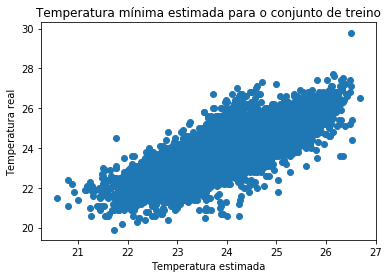

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.82645636]
 [0.82645636 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

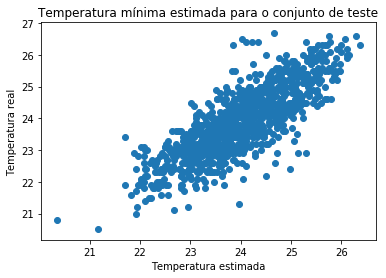

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.        0.8137439]
 [0.8137439 1.       ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.4881560485446431


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.4002256900187179


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaFortaleza.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaFortaleza.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))